# Figures for the hospitalization model

In [1]:
library(here)
source(here("setup.R"))


here() starts at /Users/stefan/workspace/work/phd/thesis



## Application 1: Showcase

In [2]:
df_files <- tibble(fname = list.files(here("data/results/4_hospitalizations/showcase"), full.names = T)) %>%
    # mutate(age_group = paste0("A", str_extract(fname, "\\d\\d-\\d\\d"))) %>%
    mutate(age_group = c("A00-04", "A00+", "A05-14", "A15-34", "A35-59", "A60-79", "A80+")) %>%
    mutate(n_delay = c(5, 8, 5, 7, 7, 8, 8))

read_age_predictions <- function(fname, n_delay) {
    dates <- seq(from = ymd("2021-11-22"), to = ymd("2022-04-28"), by = "1 day")
    variables <- c(
        "prob_hosp",
        paste0("p_delay_smooth", seq(n_delay)),
        paste0("p_delay", seq(n_delay)),
        "weekday_0",
        "weekday_1"
    )

    read_predictions(fname, dates, variables)
}

df_predictions <- df_files %>%
    mutate(data = map2(fname, n_delay, read_age_predictions)) %>%
    select(-fname, -n_delay) %>%
    unnest() %>%
    mutate(age_group = ordered_age_group(age_group))


Warning message:
"`cols` is now required when using `unnest()`.
i Please use `cols = c(data)`."


In [3]:
df_predictions %>%
    distinct(variable)


variable
<fct>
prob_hosp
p_delay_smooth1
p_delay_smooth2
p_delay_smooth3
p_delay_smooth4
p_delay_smooth5
p_delay1
p_delay2
p_delay3


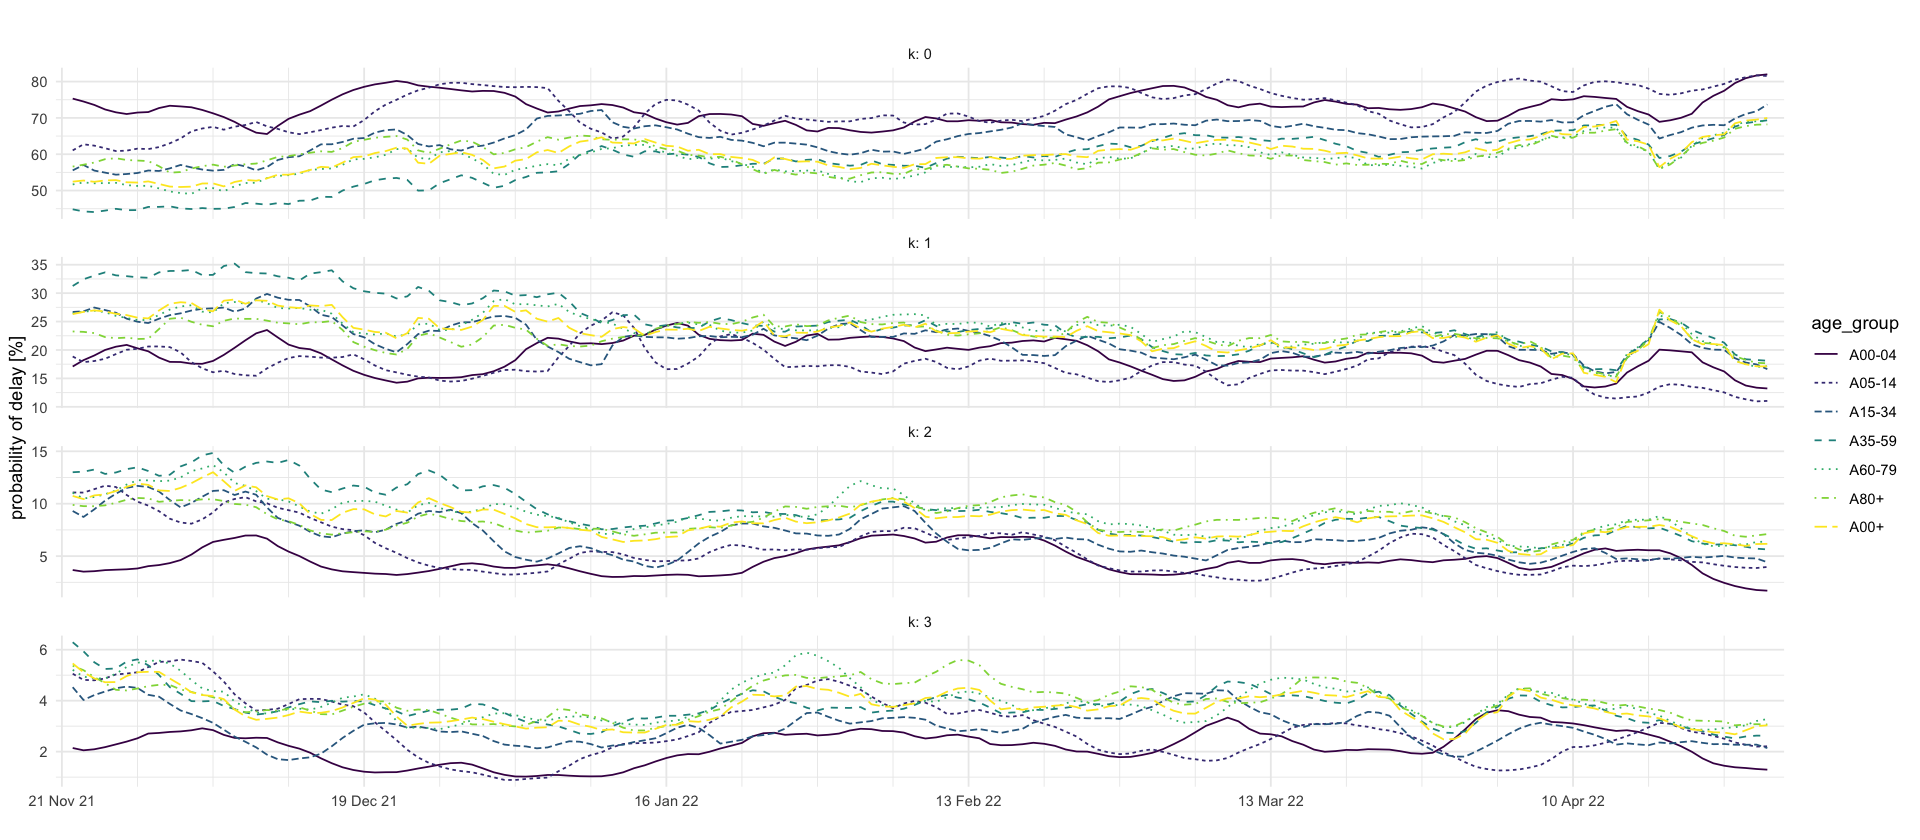

In [4]:
p_smoothed_delays <- df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(str_detect(variable, "p_delay_smooth")) %>%
    mutate(variable = str_replace(variable, "p_delay_smooth", "")) %>%
    rename(k = variable) %>%
    mutate(k = as.numeric(k) - 1) %>%
    filter(k <= 3) %>%
    ggplot(aes(x = date, y = mean * 100, color = age_group, group = age_group, linetype = age_group)) +
    geom_line() +
    # geom_ribbon(aes(ymin = `0.025` * 100, ymax = `0.975` * 100, fill = age_group), alpha = 0.2) +
    labs(
        title = "",
        x = "",
        y = "probability of delay [%]"
    ) +
    scale_x_four_weekly() +
    facet_wrap(~k, scales = "free_y", nrow = 4, labeller = label_both)
p_smoothed_delays


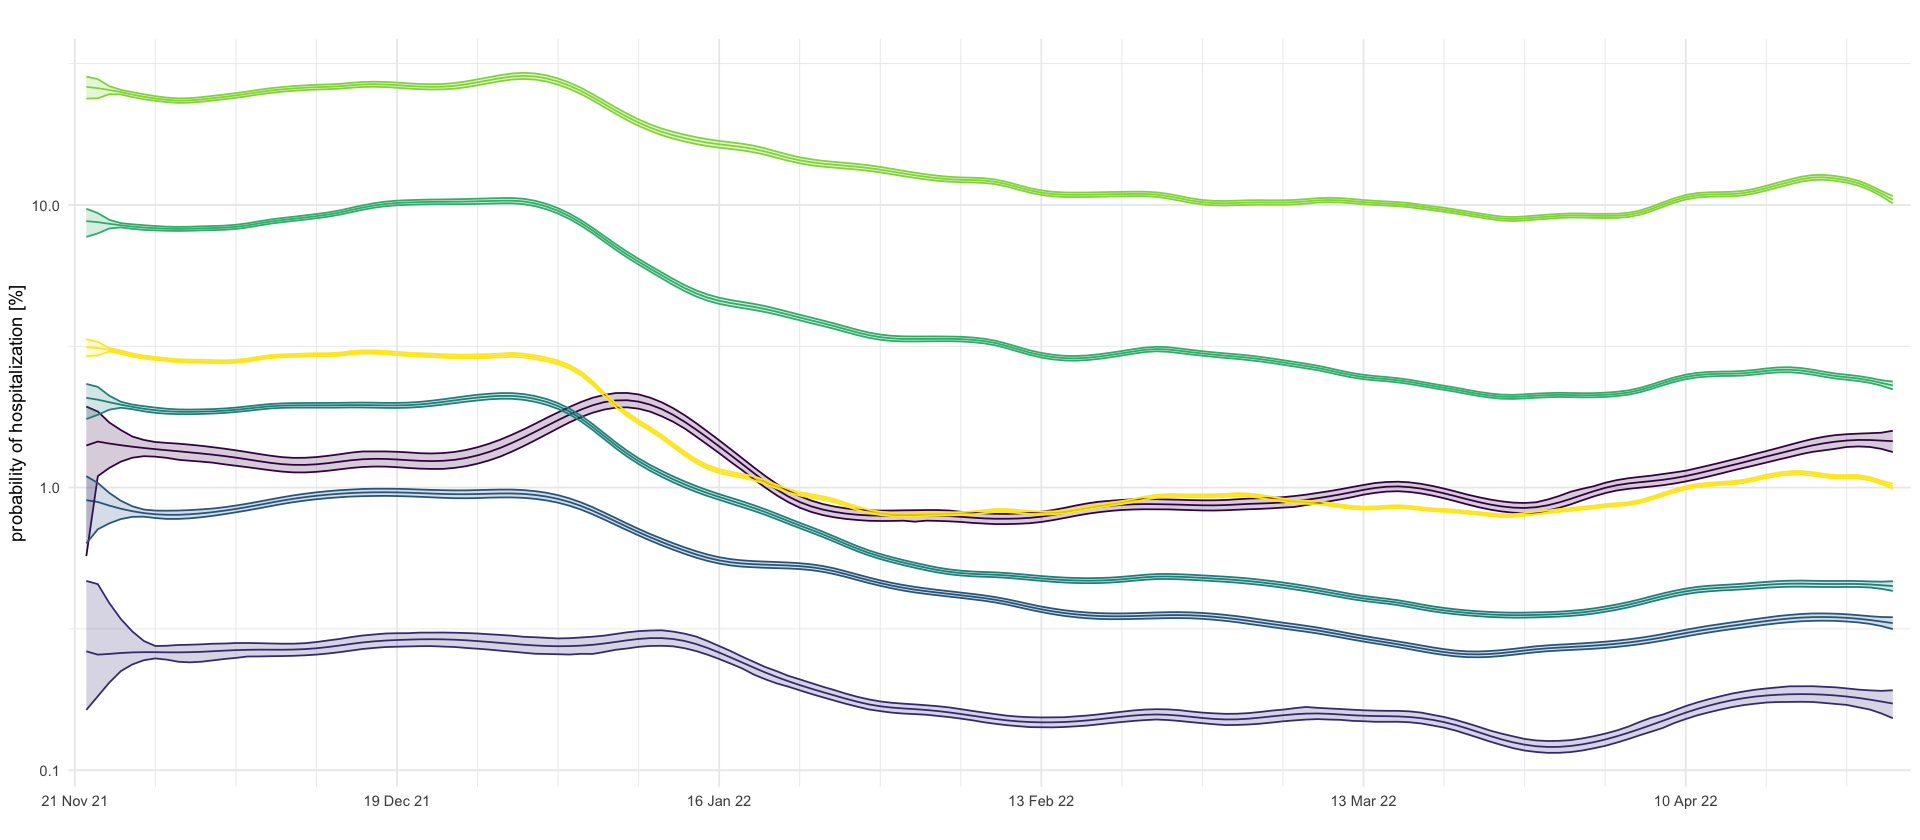

In [5]:
p_hospitalizations <- df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(variable == "prob_hosp") %>%
    ggplot(aes(x = date, y = mean * 100, color = age_group, group = age_group)) +
    geom_line() +
    geom_ribbon(aes(ymin = `0.025` * 100, ymax = `0.975` * 100, fill = age_group), alpha = 0.2) +
    labs(
        title = "",
        x = "",
        y = "probability of hospitalization [%]"
    ) +
    scale_x_four_weekly() +
    scale_y_log10() +
    theme(legend.position = "none")
p_hospitalizations


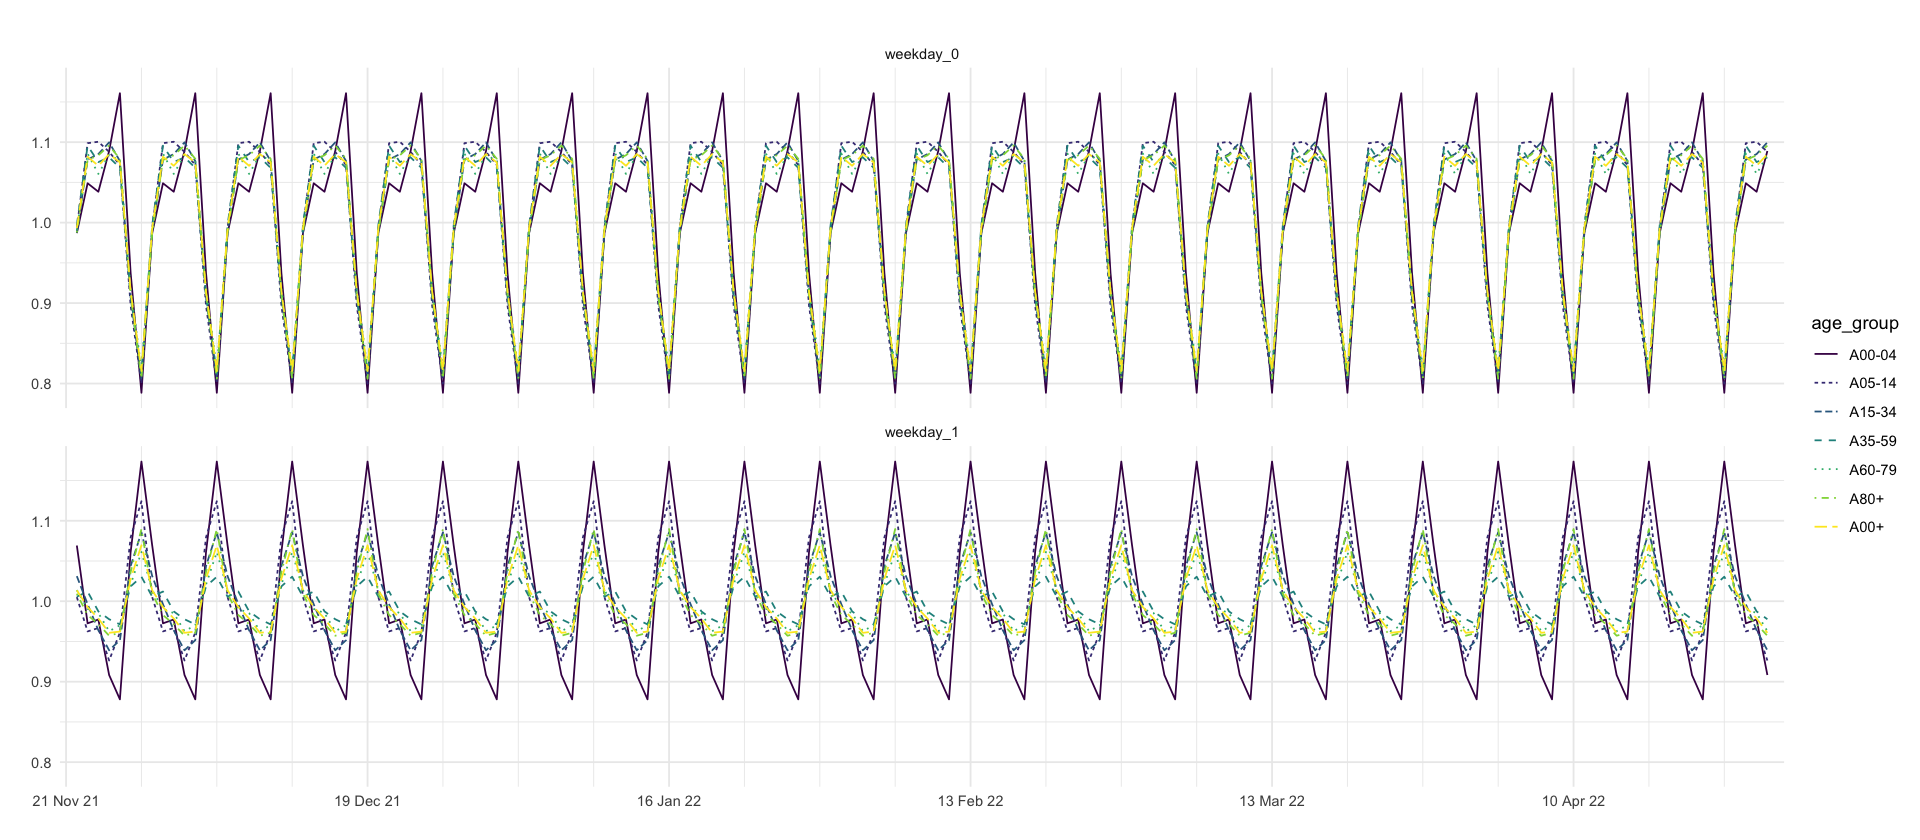

In [6]:
p_weekday <- df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(str_detect(variable, "weekday")) %>%
    ggplot(aes(x = date, y = mean, color = age_group, group = age_group, linetype = age_group)) +
    geom_line() +
    # geom_ribbon(aes(ymin = `0.025` * 100, ymax = `0.975` * 100, fill = age_group), alpha = 0.2) +
    labs(
        title = "",
        x = "",
        y = ""
    ) +
    scale_x_four_weekly() +
    facet_wrap(~variable, nrow = 2)
p_weekday


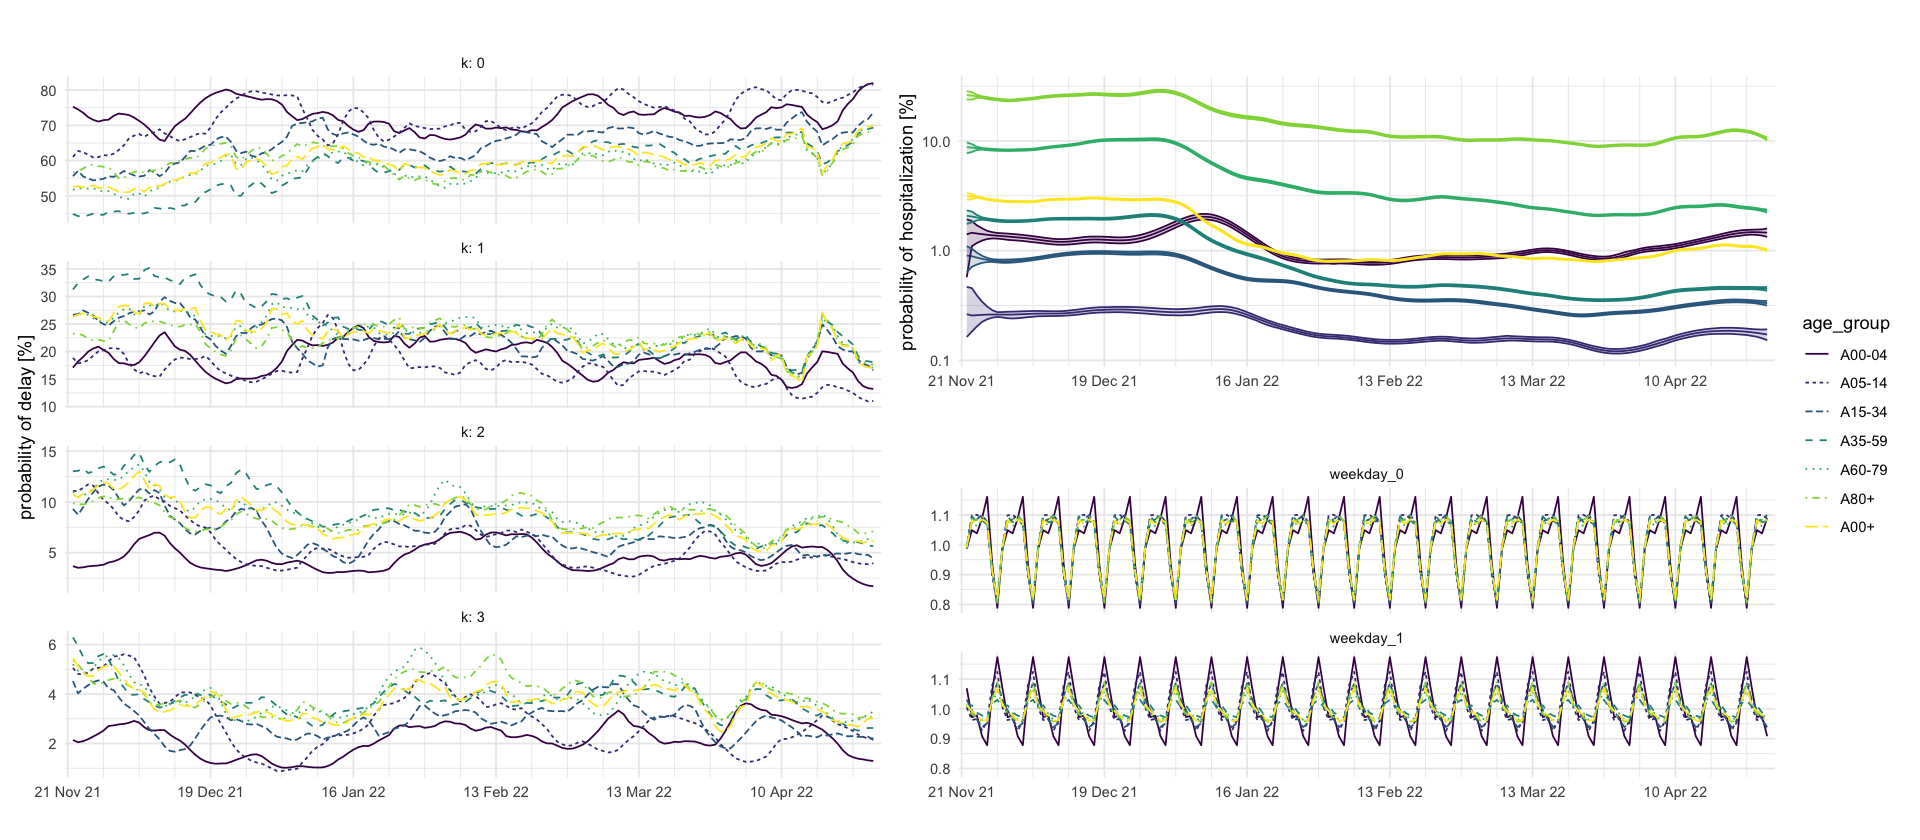

In [7]:
(p_smoothed_delays | (p_hospitalizations / p_weekday)) + plot_layout(guides = "collect")
